In [1]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import KMeans
import pgmpy
from IPython.display import Image
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict
import matplotlib.pyplot as plt

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

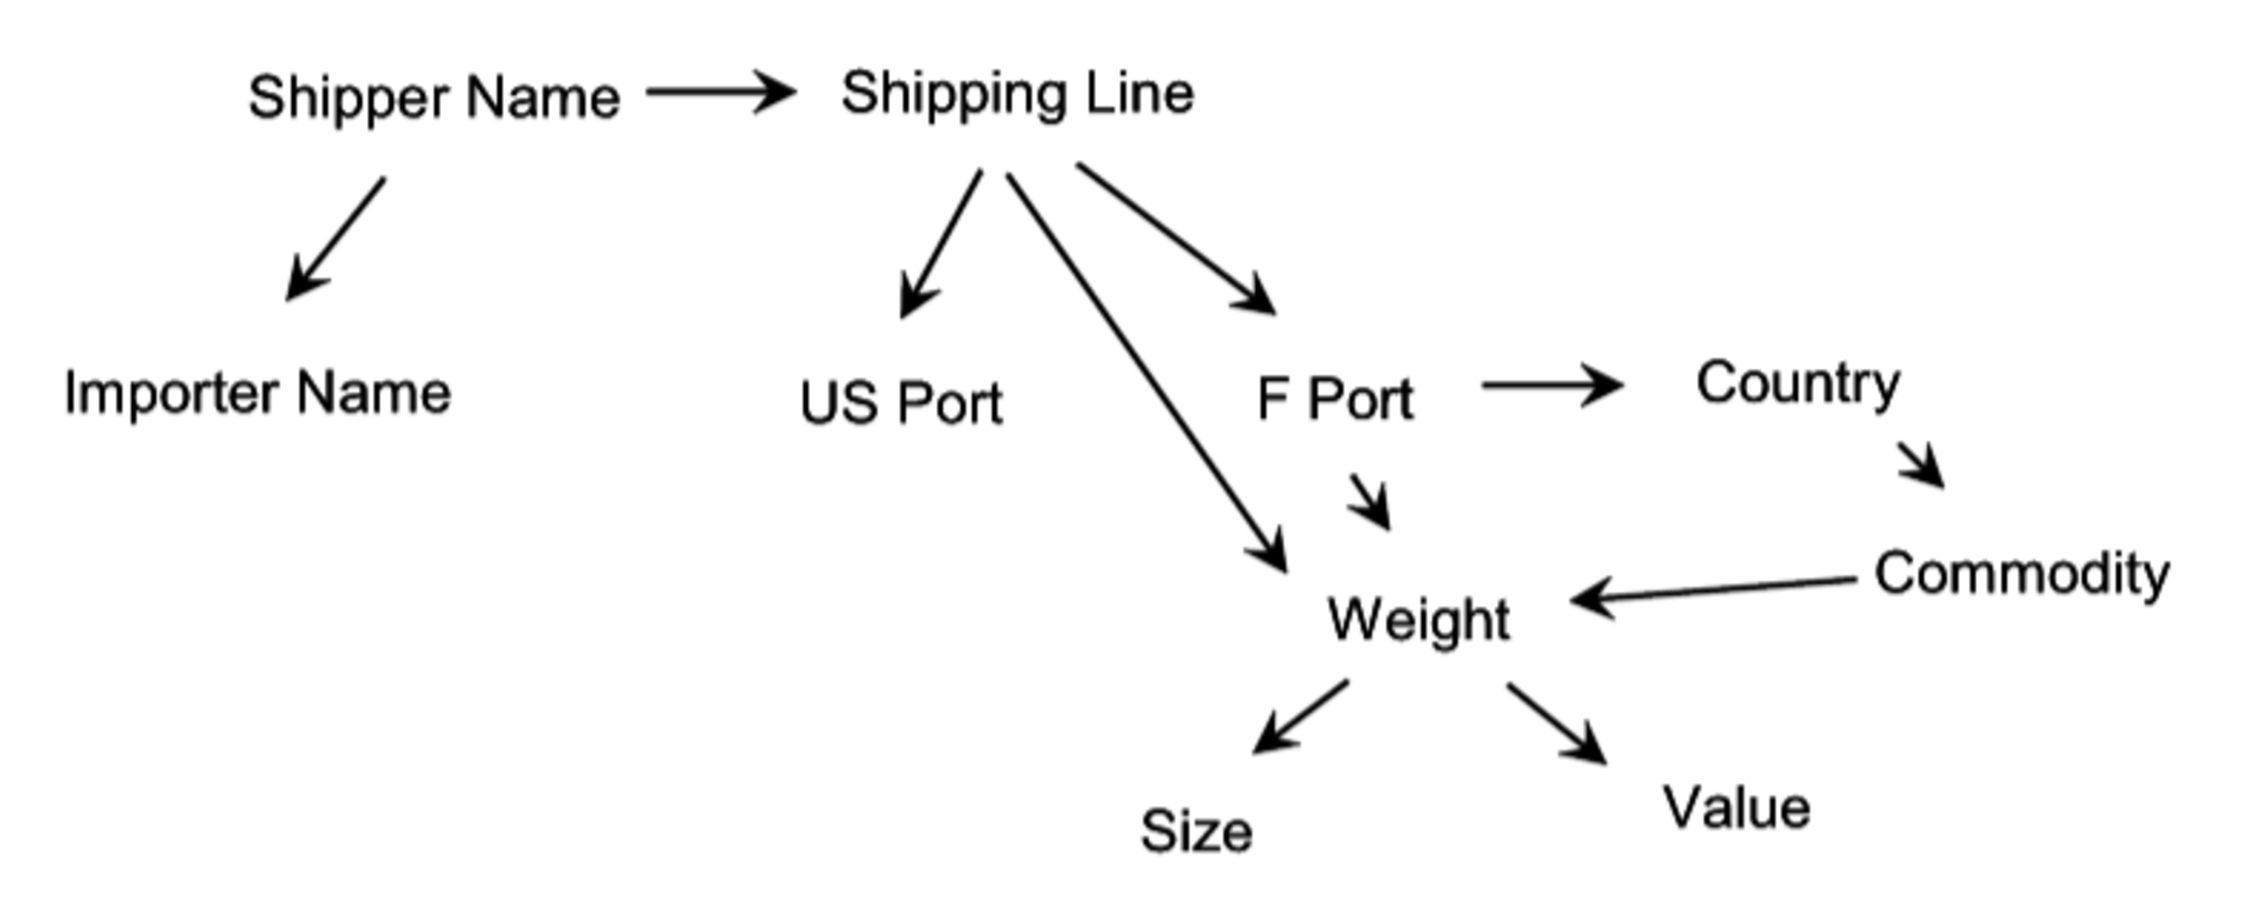

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)?

CI (Shipper Name, Value | Shipping Line)? 

CI (Foreign Port, Commodity | Country)? 

CI (Foreign Port, Commodity | County, Weight)? 

Answer:

1. Dependent
2. Independent
3. Independent
4. Dependent

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

b) A heavy package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

a) pack1  = P(Shipping Line=ASCO) P(Foreign Port=Vancouver | Shipping Line = ASCO) P(US Port = Seattle | Shipping Line = ASCO) P(Weight = Heavy | Shipping Line = ASCO, Foreign Port = Vancouver) 

        = (30/100) x (100/100)x (100/100)x (15/100) = 45/1000 = 0.045 = 4.5%

b) pack2 = P(Shipping Line=CSCO) P(Foreign Port = Vancouver | Shipping Line = CSCO) P(US Port = Seattle | Shipping Line = CSCO) P(Weight =Heavy | Shipping Line = CSCO, Foreign Port = Vancouver)
        
        = (70/100) x (60/100)x (80/100)x (20/100) = 672/10000= 0.0672 = 6.72%

c) pack3 = P(Shipping Line=CSCO) P(Foreign Port=Yokohama | Shipping Line = CSCO) P(US Port=Los Angeles | Shipping Line = CSCO) P(Weight=Heavy | Shipping Line = CSCO, Foreign Port = Yokohama) 

        = (70/100) x (40/100)x (20/100)x (60/100) = 336/10000 = 0.0336 = 3.36%

Thus, pack3 is the one with the lowest likelihood values, hence its the most anomalous.

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [3]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,0,0,0,1,0,1
2,1,1,0,1,1,1
3,1,0,0,1,1,1
4,2,0,1,0,1,1


a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [4]:
#a)

hc = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = hc.estimate()
print(best_model.edges())

/opt/anaconda3/lib/python3.7/site-packages/pgmpy/estimators/base.py:54: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  states = sorted(list(self.data.ix[:, variable].dropna().unique()))
/opt/anaconda3/lib/python3.7/site-packages/pgmpy/estimators/base.py:116: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  state_count_data = data.ix[:, variable].value_counts()


[('B', 'A'), ('D', 'A'), ('E', 'A')]


In [5]:
# b)
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
print(best_model.local_independencies(best_model.nodes()))

CPD of A:
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| B    | B(0)                 | B(0)                  | B(0)                 | B(0)                 | B(1)                  | B(1)                 | B(1)                  | B(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| D    | D(0)                 | D(0)                  | D(1)                 | D(1)                 | D(0)                  | D(0)                 | D(1)                  | D(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| E    | E

In [6]:
#c)
def temp_predict(model,data):
    missing_variables = list(set(model.nodes()) - set(data.columns))
    pred_values = defaultdict(list)
    model_inference = VariableElimination(model)
    for index, data_point in data.iterrows():
        states_dict = model_inference.map_query(variables=missing_variables, evidence=data_point.astype(int).to_dict())
        for k, v in states_dict.items():
            pred_values[k].append(v)
    return pd.DataFrame(pred_values, index=data.index)

train_x = train.loc[:,"B":"F"]

predicted_train = temp_predict(best_model, train_x)

test_x = test.loc[:,"B":"F"]
predicted_test = temp_predict(best_model, test_x)
print ("Out of sample:",(test.loc[:,'A']==predicted_test['A']).mean())

Out of sample: 0.5645


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [7]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [8]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


#### Clustering the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes

In [9]:
hours = ['hour_' + str(i) for i in range(0,24)] 
newdata = data3[hours]
km = KMeans(n_clusters = 3, random_state= 234)
res = km.fit(newdata)

In [10]:
data3['label_km'] = res.labels_
newdata['label_km'] = res.labels_

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
newdata.head()

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,label_km
0,0.073654,0.079320,0.076487,0.087819,0.082153,0.073654,0.039660,0.033994,0.014164,0.016997,...,0.019830,0.025496,0.022663,0.022663,0.053824,0.033994,0.033994,0.042493,0.062323,0
1,0.055556,0.070370,0.033333,0.014815,0.025926,0.003704,0.007407,0.014815,0.018519,0.029630,...,0.077778,0.048148,0.059259,0.044444,0.044444,0.077778,0.044444,0.074074,0.044444,0
2,0.040630,0.039580,0.033275,0.036778,0.018564,0.014011,0.012609,0.021366,0.025569,0.034676,...,0.052189,0.059895,0.056392,0.062347,0.051839,0.053240,0.066550,0.055692,0.056042,0
3,0.034000,0.026000,0.018000,0.009000,0.010000,0.015000,0.020000,0.017000,0.033000,0.036000,...,0.058000,0.073000,0.078000,0.068000,0.066000,0.059000,0.038000,0.051000,0.041000,0
4,0.009804,0.009804,0.029412,0.009804,0.009804,0.019608,0.039216,0.019608,0.000000,0.029412,...,0.009804,0.107843,0.117647,0.058824,0.068627,0.078431,0.068627,0.049020,0.088235,0


#### a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

In [12]:
df_mean = newdata.groupby(['label_km']).mean()
df_mean

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
label_km,,,,,,,,,,,,,,,,,,,,,
0,0.053642,0.041824,0.036912,0.031042,0.025106,0.018864,0.019462,0.024342,0.027668,0.033517,...,0.042090,0.047396,0.051701,0.054259,0.057579,0.055997,0.057573,0.054118,0.058373,0.052035
1,0.042486,0.012484,0.010632,0.009173,0.009353,0.007823,0.013453,0.023746,0.050991,0.092355,...,0.063096,0.068246,0.062162,0.052158,0.049157,0.041648,0.034145,0.024767,0.021921,0.018831
2,0.025789,0.014926,0.011240,0.006105,0.002769,0.001359,0.003941,0.008602,0.012127,0.024071,...,0.057547,0.044079,0.039107,0.043985,0.073090,0.106785,0.091043,0.080099,0.065787,0.039175


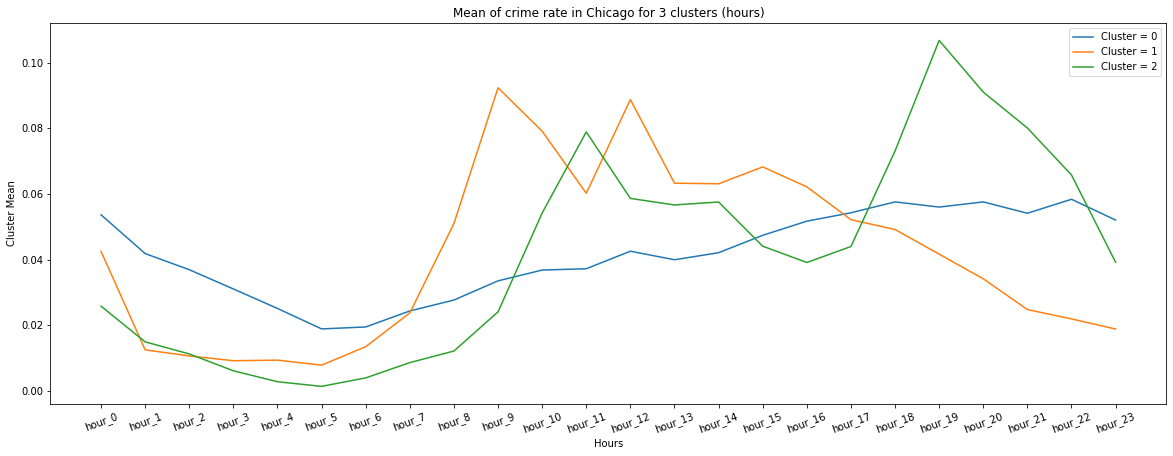

In [13]:
#draw the plot
ax = plt.figure(figsize = (20,7))
plt.plot(df_mean.loc[0], label = 'Cluster = 0')
plt.plot(df_mean.loc[1], label = 'Cluster = 1')
plt.plot(df_mean.loc[2], label = 'Cluster = 2')
plt.legend(loc = 'upper right')
plt.xlabel('Hours')
plt.xticks(rotation=20)
plt.ylabel('Cluster Mean')
plt.title('Mean of crime rate in Chicago for 3 clusters (hours)')
plt.show()

#### (b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

The 3 trends are:

Cluster 0:
1. For cluster 0, the mean crime rate decreases from hour_0 to hour_5 which is its minimum value.
2. The mean crime rate increases from hour_5 till hour_18 and is highest at hour_18
2. From hour_18 the crime rate starts increasing slowly again till hour_23.

Cluster 1:
1. For this cluster, the mean crime rate decreases from hour_0 to hour_1 after which it remains almost constant till hour_5
2. From hour_5 the crime rate starts increasing again till hour_8 where it is the maximum. From hour_8 - hour_12 the rate is high. From hour_12 onwards it starts decreasing again till hour_23.

Cluster 2: It shows a similar pattern to cluster 1
1. For cluster 2, the mean crime rate decreases from hour_0 to hour_5.
2. From hour_5, the crime rate increases till hour_10. From hour_10 to hour_16 it decreases and rises again and is the maximum at hour_19.
3. From hour_19 it starts decreasing almost uniformly till hour_23

#### c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

In [14]:
#(c)

trend = data3.groupby(['label_km','crime_type'])['Category'].count()
trend

label_km  crime_type                                   
0         ARSON: BY FIRE                                   1
          ASSAULT: AGG PO HANDS NO/MIN INJURY              1
          ASSAULT: AGGRAVATED: HANDGUN                     1
          ASSAULT: AGGRAVATED: OTHER DANG WEAPON           1
          ASSAULT: AGGRAVATED: OTHER FIREARM               1
                                                          ..
2         OTHER OFFENSE: PAROLE VIOLATION                  1
          OTHER OFFENSE: SEX OFFENDER: FAIL TO REGISTER    1
          PROSTITUTION: SOLICIT ON PUBLIC WAY              1
          PUBLIC PEACE VIOLATION: RECKLESS CONDUCT         1
          WEAPONS VIOLATION: UNLAWFUL POSS OF HANDGUN      1
Name: Category, Length: 119, dtype: int64

In [15]:
trend[0] #for cluster 0

crime_type
ARSON: BY FIRE                                       1
ASSAULT: AGG PO HANDS NO/MIN INJURY                  1
ASSAULT: AGGRAVATED: HANDGUN                         1
ASSAULT: AGGRAVATED: OTHER DANG WEAPON               1
ASSAULT: AGGRAVATED: OTHER FIREARM                   1
                                                    ..
THEFT: POCKET-PICKING                                1
THEFT: PURSE-SNATCHING                               1
WEAPONS VIOLATION: RECKLESS FIREARM DISCHARGE        1
WEAPONS VIOLATION: UNLAWFUL USE HANDGUN              1
WEAPONS VIOLATION: UNLAWFUL USE OTHER DANG WEAPON    1
Name: Category, Length: 69, dtype: int64

In [16]:
trend[1]  #for cluster 1

crime_type
ASSAULT: PRO EMP HANDS NO/MIN INJURY                           1
BATTERY: PRO EMP HANDS NO/MIN INJURY                           1
BURGLARY: UNLAWFUL ENTRY                                       1
DECEPTIVE PRACTICE: ATTEMPT - FINANCIAL IDENTITY THEFT         1
DECEPTIVE PRACTICE: BOGUS CHECK                                1
DECEPTIVE PRACTICE: COUNTERFEIT CHECK                          1
DECEPTIVE PRACTICE: CREDIT CARD FRAUD                          1
DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT $300 AND UNDER    1
DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT OVER $ 300        1
DECEPTIVE PRACTICE: FORGERY                                    1
DECEPTIVE PRACTICE: FRAUD OR CONFIDENCE GAME                   1
DECEPTIVE PRACTICE: ILLEGAL USE CASH CARD                      1
NARCOTICS: FOUND SUSPECT NARCOTICS                             1
OFFENSE INVOLVING CHILDREN: CHILD ABDUCTION                    1
OFFENSE INVOLVING CHILDREN: OTHER OFFENSE                      1
OTHER OFFENSE:

In [17]:
trend[2]  #for cluster 2

crime_type
DECEPTIVE PRACTICE: COUNTERFEITING DOCUMENT                     1
GAMBLING: GAME/DICE                                             1
INTERFERENCE WITH PUBLIC OFFICER: OBSTRUCTING IDENTIFICATION    1
NARCOTICS: MANU/DEL:CANNABIS 10GM OR LESS                       1
NARCOTICS: MANU/DEL:CANNABIS OVER 10 GMS                        1
NARCOTICS: MANU/DELIVER: HEROIN (WHITE)                         1
NARCOTICS: MANU/DELIVER:CRACK                                   1
NARCOTICS: POSS: CANNABIS 30GMS OR LESS                         1
NARCOTICS: POSS: CANNABIS MORE THAN 30GMS                       1
NARCOTICS: POSS: CRACK                                          1
NARCOTICS: POSS: HEROIN(WHITE)                                  1
NARCOTICS: POSS: PCP                                            1
NARCOTICS: POSS: SYNTHETIC DRUGS                                1
NARCOTICS: POSSESSION OF DRUG EQUIPMENT                         1
NARCOTICS: SOLICIT NARCOTICS ON PUBLICWAY                       1

Hence,

Cluster 0 contains mostly crimes that are AGGRAVATED ASSAULT, THEFT (such as purse snatching) and WEAPONS VIOLATION

Cluster 1 contains mostly crimes that are DECEPTIVE PRACTICE (such as credit card fraud, financial identity theft, forgery) and theft such as pick pocketing, BURGLARY and OFFENSE INVOLVING CHILDREN

Cluster 2 contains mostly crimes that involve NARCOTICS possession/manufacture/deliver and others such as GUN OFFENDER, PAROLE VIOLATION, LICENSE VIOLATION

#### d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)



In [18]:
days = data3.iloc[:,[2,3,4,5,6,7,8,110]]
newdata2 = days.groupby(['label_km']).mean()
newdata2

,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat
label_km,,,,,,,
0,0.146923,0.140521,0.138356,0.135286,0.137113,0.149810,0.151992
1,0.108502,0.150429,0.152455,0.153047,0.153902,0.158629,0.123036
2,0.115915,0.140945,0.160049,0.148696,0.145199,0.156605,0.132593


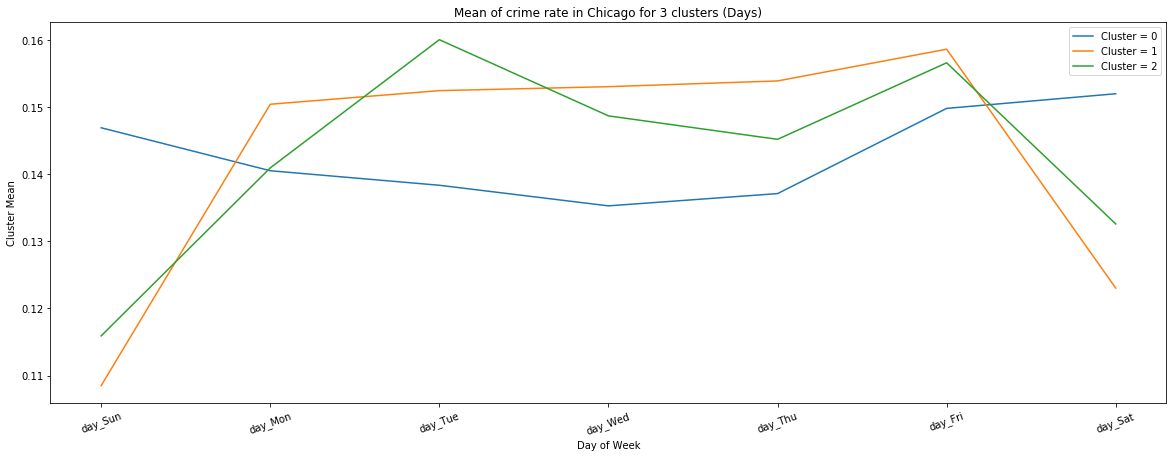

In [19]:
ax = plt.figure(figsize = (20,7))
plt.plot(newdata2.loc[0], label = 'Cluster = 0')
plt.plot(newdata2.loc[1], label = 'Cluster = 1')
plt.plot(newdata2.loc[2], label = 'Cluster = 2')
plt.legend(loc = 'upper right')
plt.xlabel('Day of Week')
plt.xticks(rotation=20)
plt.ylabel('Cluster Mean')
plt.title('Mean of crime rate in Chicago for 3 clusters (Days)')
plt.show()

#### DIFFERENCES:

This graph shows day wise trend of crimes in the 3 clusters as compared to mean hourly crime rate before.

For Cluster 1 and 2, most of the crimes occur from monday to friday and decrease sharply on saturday and sunday. Thus we can say that the crimes such as:  credit card fraud, financial identity theft, forgery, narcotics possession increases over the weekdays and decreases over weekends.

For cluster 0, the crimes from monday - thursday are the minimum and almost constant and increases over the weekend (on saturday and sunday). Then decreases over the weekdays. Thus we can say that the crimes such as: AGGRAVATED ASSAULT, THEFT (such as purse snatching) and WEAPONS VIOLATION increases over the weekends and decreases during weekdays.

#### e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

In [20]:
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,label_km
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833,0
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407,0
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152,0
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000,0
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000,0


In [21]:
comm = data3.loc[:,'community_area_1':'label_km']
df_comm = comm.groupby(['label_km']).mean()
df_comm

,community_area_1,community_area_2,community_area_3,community_area_4,community_area_5,community_area_6,community_area_7,community_area_8,community_area_9,community_area_10,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
label_km,,,,,,,,,,,,,,,,,,,,,
0,0.014190,0.012614,0.013718,0.007307,0.004148,0.021163,0.010299,0.027837,0.000690,0.003514,...,0.026130,0.028922,0.009371,0.028839,0.002854,0.011386,0.001584,0.007115,0.010147,0.007367
1,0.014446,0.014380,0.016437,0.010941,0.007502,0.024766,0.018054,0.053912,0.002169,0.007858,...,0.017873,0.020703,0.010150,0.023909,0.005234,0.011028,0.004348,0.009446,0.009696,0.012677
2,0.007818,0.005919,0.007367,0.002166,0.001113,0.006101,0.001626,0.013915,0.000376,0.001264,...,0.038343,0.027435,0.002366,0.033006,0.000951,0.010082,0.000555,0.007153,0.000911,0.001522


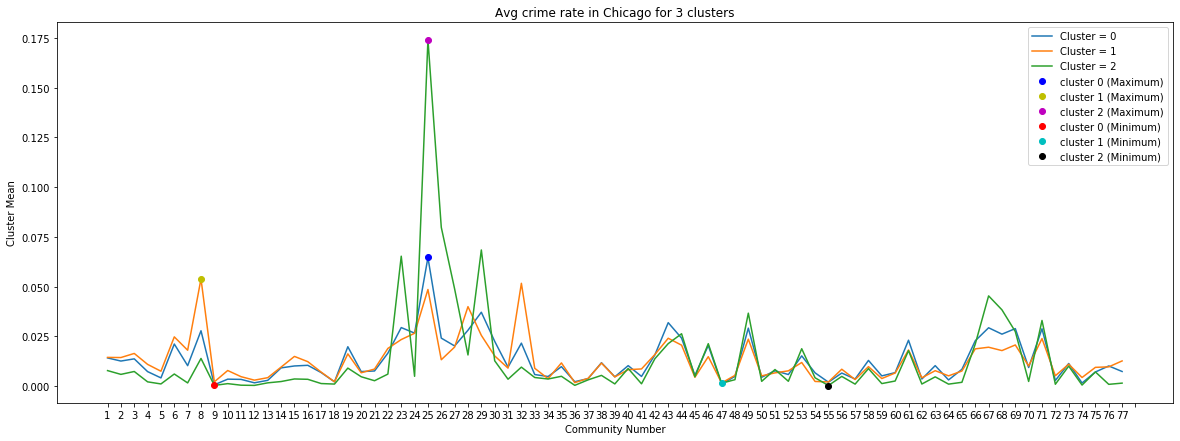

In [22]:
ax = plt.figure(figsize = (20,7))
plt.plot(df_comm.loc[0], label = 'Cluster = 0')
plt.plot(df_comm.loc[1], label = 'Cluster = 1')
plt.plot(df_comm.loc[2], label = 'Cluster = 2')

#For max value:
max_point_c0 = plt.plot(df_comm.loc[0].idxmax(), max(df_comm.loc[0]), 'bo', label="cluster 0 (Maximum)")
max_point_c1 = plt.plot(df_comm.loc[1].idxmax(), max(df_comm.loc[1]), 'yo', label="cluster 1 (Maximum)")
max_point_c2 = plt.plot(df_comm.loc[2].idxmax(), max(df_comm.loc[2]), 'mo', label="cluster 2 (Maximum)")

#For min value
min_point_c0 = plt.plot(df_comm.loc[0].idxmin(), min(df_comm.loc[0]), 'ro', label="cluster 0 (Minimum)")
min_point_c1 = plt.plot(df_comm.loc[1].idxmin(), min(df_comm.loc[1]), 'co', label="cluster 1 (Minimum)")
min_point_c2 = plt.plot(df_comm.loc[2].idxmin(), min(df_comm.loc[2]), 'ko', label="cluster 2 (Minimum)")

plt.ylabel('Cluster Mean')
plt.xlabel('Community Number')
plt.xticks(range(0,78),range(1,78))
plt.title('Avg crime rate in Chicago for 3 clusters')
plt.legend(loc = 'upper right')
plt.show()

From the figure we can focus on the maximum values of the cluster as minimum values are almost 0. We'll focus on top 5 values

In [23]:
df_comm.loc[0].nlargest(5)

community_area_25    0.064651
community_area_29    0.037146
community_area_43    0.031902
community_area_23    0.029437
community_area_67    0.029338
Name: 0, dtype: float64

In [39]:
df_comm_0 = data4.loc[data4['Community Area Number'].isin([25,29,43,23,67])]
df_comm_0.loc['mean'] = data4.mean()
df_comm_0

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
22,23.0,Humboldt park,1.151216e+06,1.906926e+06,14.800000,33.900000,17.300000,35.400000,38.000000,13781.000000,15.839488,7522.000000
24,25.0,Austin,1.140839e+06,1.903174e+06,6.300000,28.600000,22.600000,24.400000,37.900000,15957.000000,14.188517,15719.000000
28,29.0,North Lawndale,1.152306e+06,1.892569e+06,7.400000,43.100000,21.200000,27.600000,42.700000,12034.000000,21.888178,8073.000000
42,43.0,South Shore,1.191640e+06,1.856742e+06,2.800000,31.100000,20.000000,14.000000,35.700000,19398.000000,18.541882,7673.000000
66,67.0,West Englewood,1.166461e+06,1.861782e+06,4.800000,34.400000,35.900000,26.300000,40.700000,11317.000000,22.388616,6442.000000
mean,39.0,NaN,1.163753e+06,1.884761e+06,4.923377,21.766234,15.372727,20.341558,35.746753,25563.168831,12.442935,3262.246753


In [25]:
df_comm.loc[1].nlargest(5)

community_area_8     0.053912
community_area_32    0.051680
community_area_25    0.048565
community_area_28    0.039949
community_area_24    0.026575
Name: 1, dtype: float64

In [40]:
df_comm_1 = data4.loc[data4['Community Area Number'].isin([8,32,25,28,24])]
df_comm_1.loc['mean'] = data4.mean()
df_comm_1

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
7,8.0,Near North Side,1.175512e+06,1.906089e+06,1.900000,12.900000,7.000000,2.500000,22.600000,88669.000000,17.077160,9847.000000
23,24.0,West Town,1.163041e+06,1.907678e+06,2.300000,14.700000,6.600000,12.900000,21.700000,43198.000000,8.734616,7754.000000
24,25.0,Austin,1.140839e+06,1.903174e+06,6.300000,28.600000,22.600000,24.400000,37.900000,15957.000000,14.188517,15719.000000
27,28.0,Near West Side,1.167030e+06,1.898360e+06,3.800000,20.600000,10.700000,9.600000,22.200000,44689.000000,11.790159,8891.000000
31,32.0,Loop,1.176374e+06,1.899831e+06,1.500000,14.700000,5.700000,3.100000,13.500000,65526.000000,24.629080,8471.000000
mean,39.0,NaN,1.163753e+06,1.884761e+06,4.923377,21.766234,15.372727,20.341558,35.746753,25563.168831,12.442935,3262.246753


In [27]:
df_comm.loc[2].nlargest(5)

community_area_25    0.174141
community_area_26    0.079803
community_area_29    0.068435
community_area_23    0.065303
community_area_27    0.048817
Name: 2, dtype: float64

In [28]:
df_comm_2 = data4.loc[data4['Community Area Number'].isin([25,26,29,23,27])]
df_comm_2.loc['mean'] = data4.mean()
df_comm_2

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
22,23.0,Humboldt park,1.151216e+06,1.906926e+06,14.800000,33.900000,17.300000,35.400000,38.000000,13781.000000,15.839488,7522.000000
24,25.0,Austin,1.140839e+06,1.903174e+06,6.300000,28.600000,22.600000,24.400000,37.900000,15957.000000,14.188517,15719.000000
25,26.0,West Garfield Park,1.148755e+06,1.898786e+06,9.400000,41.700000,25.800000,24.500000,43.600000,10934.000000,27.504936,5340.000000
26,27.0,East Garfield Park,1.155087e+06,1.898653e+06,8.200000,42.400000,19.600000,21.300000,43.200000,12961.000000,19.899589,4727.000000
28,29.0,North Lawndale,1.152306e+06,1.892569e+06,7.400000,43.100000,21.200000,27.600000,42.700000,12034.000000,21.888178,8073.000000
mean,39.0,NaN,1.163753e+06,1.884761e+06,4.923377,21.766234,15.372727,20.341558,35.746753,25563.168831,12.442935,3262.246753


From the data in different clusters, we can see that the places with lower per capitaincome tend to have higher number of crimes. For example in Cluster 1, Austin has per capita income of 15957 and has a huge  number of crimes (15719).

In cluster 0 , most of the places have a higher percentage of people over 64 so they can be more susceptable to crimes such as theft, purse snatching etc which is prevailent in cluster 0. 

In cluster 2,PERCENTAFE OF PEOPLE AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA and PERCENT AGED 16+ UNEMPLOYED is high which might lead them to do narcotics related crimes.

#### f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

In [29]:
fbi = data3[['Category','label_km']]
for i in range(0,3):
    print('for cluster %d' %i)
    print(fbi[fbi['label_km']==i].Category.value_counts())
    print(fbi[fbi['label_km']==i].Category.value_counts(normalize=True))
    print('\n')

for cluster 0
P2     34
P1V    24
P1P    11
Name: Category, dtype: int64
P2     0.492754
P1V    0.347826
P1P    0.159420
Name: Category, dtype: float64


for cluster 1
P2     23
P1P     4
Name: Category, dtype: int64
P2     0.851852
P1P    0.148148
Name: Category, dtype: float64


for cluster 2
P2    23
Name: Category, dtype: int64
P2    1.0
Name: Category, dtype: float64




Cluster 0 has a higher propotional value for P1V and P2 for FBI as compared to cluster 1,2. Cluster 1 shows the lowest value for these. This might make it more susceptable to the attacks such as identity theft, forgery which is prevailant in this cluster.

#### g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)

In [30]:
df_cluster = data3.loc[:,"day_Sun":"day_Sat"]

#### (1) k- means clustering

In [31]:
# using silhouette score

cluster1 = {}
for n_clusters in range(2,15):
    m = KMeans(n_clusters=n_clusters, random_state=2020)
    pred1 = m.fit_predict(df_cluster)

    score1 = silhouette_score(df_cluster, pred1)
    print ("Number of clusters = {}, Silhouette score = {})".format(n_clusters, score1))
    cluster1[n_clusters] = score1

Number of clusters = 2, Silhouette score = 0.2349670398022404)
Number of clusters = 3, Silhouette score = 0.21796439750751376)
Number of clusters = 4, Silhouette score = 0.22004272745677095)
Number of clusters = 5, Silhouette score = 0.24342891469944264)
Number of clusters = 6, Silhouette score = 0.16265988452994937)
Number of clusters = 7, Silhouette score = 0.1714127339358097)
Number of clusters = 8, Silhouette score = 0.17644409810421113)
Number of clusters = 9, Silhouette score = 0.1385279446522909)
Number of clusters = 10, Silhouette score = 0.16522658161652623)
Number of clusters = 11, Silhouette score = 0.14801852697377182)
Number of clusters = 12, Silhouette score = 0.13805236112021302)
Number of clusters = 13, Silhouette score = 0.15014247301396028)
Number of clusters = 14, Silhouette score = 0.1532091037000221)


In [32]:
best_kmeans = KMeans(n_clusters = 5, random_state= 2020)
model_kmeans = best_kmeans.fit(df_cluster)
df_kmeans2 = df_cluster.copy()
df_kmeans2['label_km'] = model_kmeans.labels_

print ("\n The cluster number for k-means is: %d" %max(cluster1, key=cluster1.get))
print ("Elements in each Cluster: ")
print (df_kmeans2['label_km'].value_counts())


 The cluster number for k-means is: 5
Elements in each Cluster: 
3    59
0    45
1    10
2     3
4     2
Name: label_km, dtype: int64


#### ii) Gaussian mixture models

In [33]:
# using silhouette score

cluster2 = {}
for n_clusters in range(2,15):
    gm = GaussianMixture(n_components=n_clusters, random_state=2020)
    pred2 = gm.fit_predict(df_cluster)

    score_gmm = silhouette_score (df_cluster, pred2)
    print ("Number of clusters = {}, Silhouette score = {})".format(n_clusters, score_gmm))
    cluster2[n_clusters] = score_gmm

Number of clusters = 2, Silhouette score = 0.25672726757004694)
Number of clusters = 3, Silhouette score = 0.27257976718174254)
Number of clusters = 4, Silhouette score = 0.057368137088243086)
Number of clusters = 5, Silhouette score = 0.14335079237564585)
Number of clusters = 6, Silhouette score = 0.12806538474491866)
Number of clusters = 7, Silhouette score = 0.10441622878966021)
Number of clusters = 8, Silhouette score = 0.15346414559158172)
Number of clusters = 9, Silhouette score = 0.17510251560235918)
Number of clusters = 10, Silhouette score = 0.09338910611167077)
Number of clusters = 11, Silhouette score = 0.09928229645558859)
Number of clusters = 12, Silhouette score = 0.11498944758842679)
Number of clusters = 13, Silhouette score = 0.11725743885258903)
Number of clusters = 14, Silhouette score = 0.13587530795750968)


In [34]:
gmm = GaussianMixture(n_components=3, random_state=2020)
fit_gmm = gmm.fit_predict(df_cluster)

gmm2 = df_cluster.copy()
gmm2['label_gmm'] = fit_gmm

print ("\n The cluster number for Gaussian Mixture is: %d" %max(cluster2, key=cluster2.get))
print ("Elements in each Cluster: ")
print (gmm2['label_gmm'].value_counts())


 The cluster number for Gaussian Mixture is: 3
Elements in each Cluster: 
0    85
1    23
2    11
Name: label_gmm, dtype: int64


#### iii) Bottom-up hierarchical clustering with "single link" distance metric

In [35]:
# using silhouette score

slc = linkage(df_cluster, 'single')
cluster3 = {}
for n_clusters in range(2,15):
    pred3 = fcluster(slc, n_clusters, criterion='maxclust')

    score3 = silhouette_score(df_cluster, pred3)
    print ("Number of clusters = {}, Silhouette score = {})".format(n_clusters, score3))
    cluster3[n_clusters] = score3

Number of clusters = 2, Silhouette score = 0.6377648080667613)
Number of clusters = 3, Silhouette score = 0.5568477382969328)
Number of clusters = 4, Silhouette score = 0.40557775075981567)
Number of clusters = 5, Silhouette score = 0.38770381887486705)
Number of clusters = 6, Silhouette score = 0.3900761951022192)
Number of clusters = 7, Silhouette score = 0.3462184482039438)
Number of clusters = 8, Silhouette score = 0.32899815764355905)
Number of clusters = 9, Silhouette score = 0.32542192748924165)
Number of clusters = 10, Silhouette score = 0.3132151039050357)
Number of clusters = 11, Silhouette score = 0.21831462782301697)
Number of clusters = 12, Silhouette score = 0.15913660974826932)
Number of clusters = 13, Silhouette score = 0.08885073202230036)
Number of clusters = 14, Silhouette score = 0.03419294806094897)


In [36]:
slc_label=fcluster(slc, 2, criterion='maxclust') 
df_slc=df_cluster.copy()
df_slc['label_slc'] = slc_label

print ("\n The cluster number for Single link is: %d" %max(cluster3, key=cluster3.get))
print ("Elements in each Cluster: ")
print (df_slc['label_slc'].value_counts())



 The cluster number for Single link is: 2
Elements in each Cluster: 
1    118
2      1
Name: label_slc, dtype: int64


#### (iv) Bottom-up hierarchical clustering with "complete link" distance metric

In [37]:
# using silhouette score

clc = linkage(df_cluster, 'complete')
cluster4 = {}
for n_clusters in range(2,15):
    pred4 = fcluster(clc, n_clusters, criterion='maxclust')

    score4 = silhouette_score(df_cluster, pred4)
    print ("Number of clusters = {}, Silhouette score = {})".format(n_clusters, score4))
    cluster4[n_clusters] = score4

Number of clusters = 2, Silhouette score = 0.6100646113547021)
Number of clusters = 3, Silhouette score = 0.17268718146566123)
Number of clusters = 4, Silhouette score = 0.19215169374768618)
Number of clusters = 5, Silhouette score = 0.15025207822499778)
Number of clusters = 6, Silhouette score = 0.15229681572228093)
Number of clusters = 7, Silhouette score = 0.14926267616109448)
Number of clusters = 8, Silhouette score = 0.10130440123428044)
Number of clusters = 9, Silhouette score = 0.10066503899164779)
Number of clusters = 10, Silhouette score = 0.11061132431547081)
Number of clusters = 11, Silhouette score = 0.12537141856431583)
Number of clusters = 12, Silhouette score = 0.1141838330362258)
Number of clusters = 13, Silhouette score = 0.11216165708562797)
Number of clusters = 14, Silhouette score = 0.10909628423478158)


In [38]:
clc_label=fcluster(clc, 2, criterion='maxclust') 
df_clc=df_cluster.copy()
df_clc['label_clc'] = clc_label
print ("\n The cluster number for Complete link is: %d" %max(cluster4, key=cluster4.get))
print ("Elements in each Cluster: ")
print (df_clc['label_clc'].value_counts())


 The cluster number for Complete link is: 2
Elements in each Cluster: 
2    117
1      2
Name: label_clc, dtype: int64


#### Observations:

Both Single link and complete link clusterings have same cluster numbers = 2. One of this cluster contains most of the elements (117 for complete link clustering and 118 for single link clustering) and the other cluster contains 1 or 2 elements.

For k means the number of clusters = 5 and for GMM no of clusters = 3 which is different from Single Link Clustering and Complete Link Clustering